In [1]:
from pathlib import Path
from python.optimization import TopOpt
from python.postprocessor import Post2D, Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt.set_paths(ANSYS_path, script_dir, res_dir, mod_dir)

# Test case
- Half MBB 168 mm x 80 mm x 8 mm
- Mesh:
    - **2D**: 42 x 20 elements (4 mm element)
    - **3D**: 42 x 20 x 2 elements (4 mm element)
- 1 kN downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- r_rho = 8
- r_theta = 20
- theta0 = -45°
- 150 iterations

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
nuyz = nuxy * (1-nuxy*Ey/Ex)/(1-nuxy)
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver1 = TopOpt(inputfile='mbb2d', dim='2D', jobname='2d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuyz, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=-45, max_iter=150)
solver1.optim()

print()
print('Total elapsed time     {:7.2f}s'.format(solver1.time))
print('FEA time               {:7.2f}s'.format(solver1.fea_time))
print('Derivation time        {:7.2f}s'.format(solver1.deriv_time))
print('Variable updating time {:7.2f}s'.format(solver1.mma.update_time))

Iteration   0...  compliance = 39084.4623
Iteration   1...  compliance = 11915.7341
Iteration   2...  compliance =  8412.9312
Iteration   3...  compliance =  6699.9643
Iteration   4...  compliance =  4940.5959
Iteration   5...  compliance =  4790.9953
Iteration   6...  compliance =  4188.0398
Iteration   7...  compliance =  4505.3227
Iteration   8...  compliance =  4161.9446
Iteration   9...  compliance =  4259.2705
Iteration  10...  compliance =  4296.7958
Iteration  11...  compliance =  4322.2083
Iteration  12...  compliance =  4324.3784
Iteration  13...  compliance =  4317.6633
Iteration  14...  compliance =  4287.6095
Iteration  15...  compliance =  4252.3290
Iteration  16...  compliance =  4178.3103
Iteration  17...  compliance =  4181.6831
Iteration  18...  compliance =  4072.2467
Iteration  19...  compliance =  4107.4665
Iteration  20...  compliance =  4047.4939
Iteration  21...  compliance =  3910.2638
Iteration  22...  compliance =  4061.7362
Iteration  23...  compliance =  38

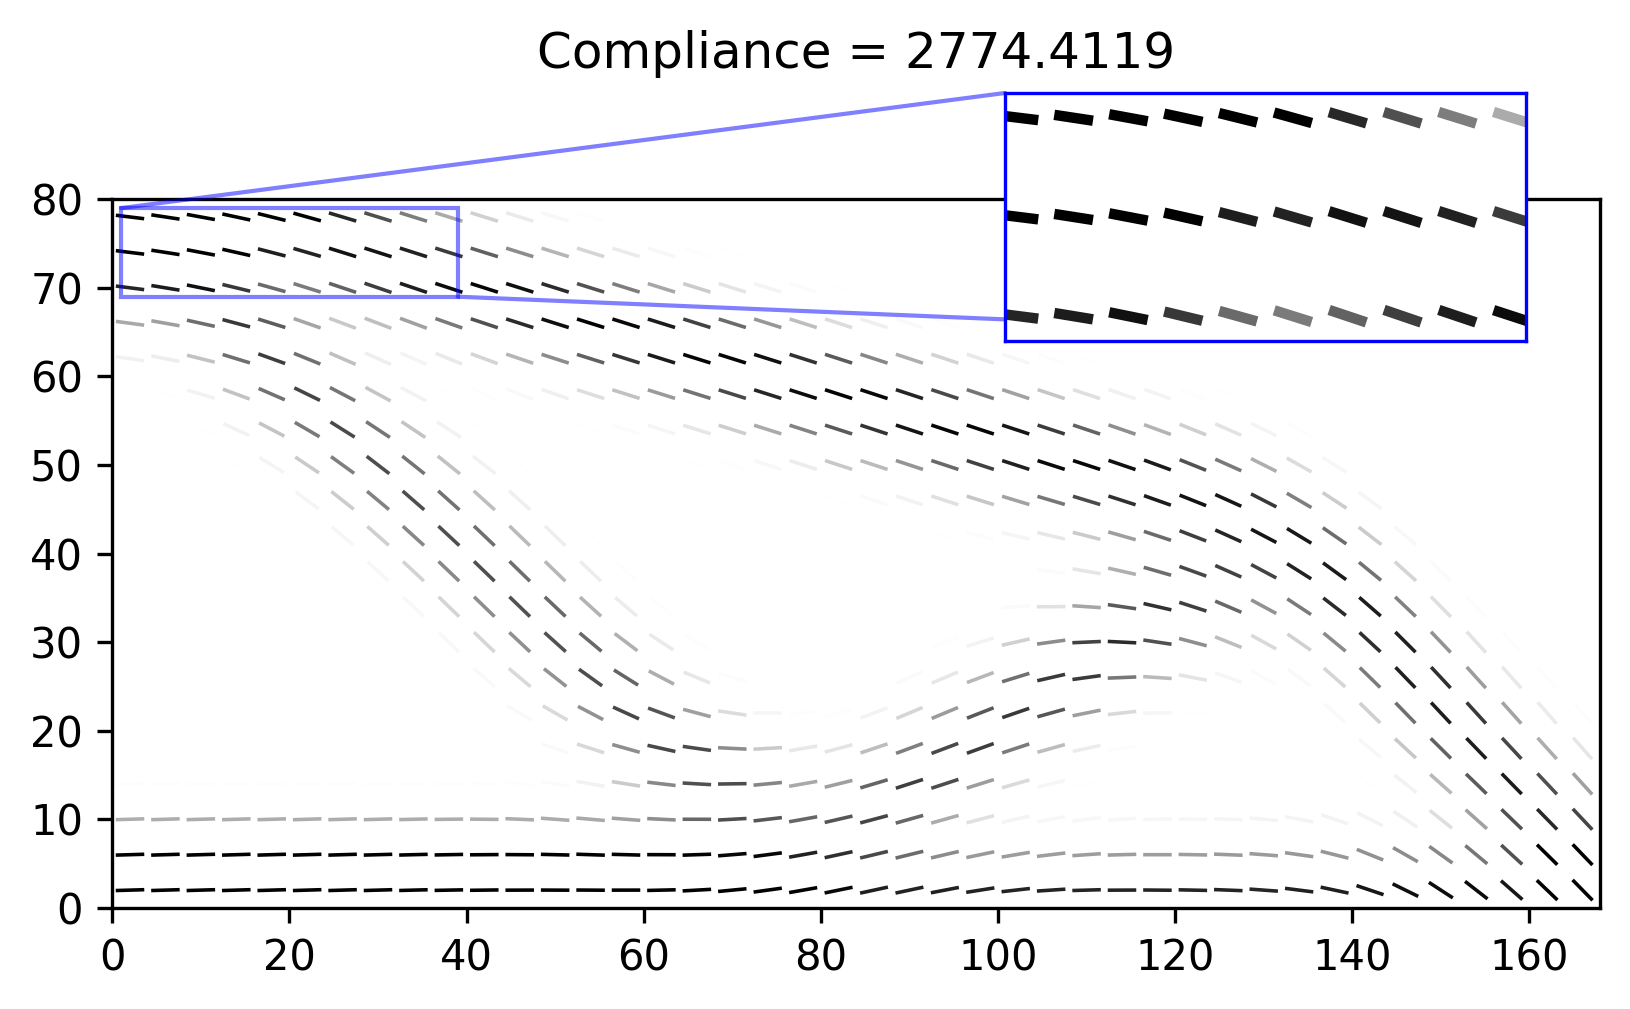

In [4]:
post1 = Post2D(solver1)
zoom = {'xmin': 1, 'xmax': 39,
       'ymin': 69, 'ymax': 79,
       'xpos': 0.6, 'ypos': 0.8,
       'width': 0.35, 'height': 0.35,
       'color': 'blue'}
post1.plot(zoom=zoom)

In [5]:
solver2 = TopOpt(inputfile='mbb3d', dim='3D_layer', jobname='3d',
                Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=nuyz, Gxy=Gxy, volfrac=0.3, r_rho=8, r_theta=20, theta0=-45, max_iter=150)
solver2.optim()

print()
print('Total elapsed time:     {:7.2f}s'.format(solver2.time))
print('FEA time:               {:7.2f}s'.format(solver2.fea_time))
print('Derivation time:        {:7.2f}s'.format(solver2.deriv_time))
print('Variable updating time: {:7.2f}s'.format(solver2.mma.update_time))

Iteration   0...  compliance = 39920.3570
Iteration   1...  compliance = 12051.1380
Iteration   2...  compliance =  8567.5597
Iteration   3...  compliance =  6666.1333
Iteration   4...  compliance =  5061.7243
Iteration   5...  compliance =  4924.2229
Iteration   6...  compliance =  4169.7656
Iteration   7...  compliance =  4394.8814
Iteration   8...  compliance =  4212.8507
Iteration   9...  compliance =  4354.0641
Iteration  10...  compliance =  4297.7778
Iteration  11...  compliance =  4351.9356
Iteration  12...  compliance =  4343.0788
Iteration  13...  compliance =  4329.6551
Iteration  14...  compliance =  4291.7981
Iteration  15...  compliance =  4253.9285
Iteration  16...  compliance =  4202.7571
Iteration  17...  compliance =  4144.7125
Iteration  18...  compliance =  4174.4992
Iteration  19...  compliance =  3991.1598
Iteration  20...  compliance =  4142.3610
Iteration  21...  compliance =  3891.6878
Iteration  22...  compliance =  3943.6299
Iteration  23...  compliance =  38

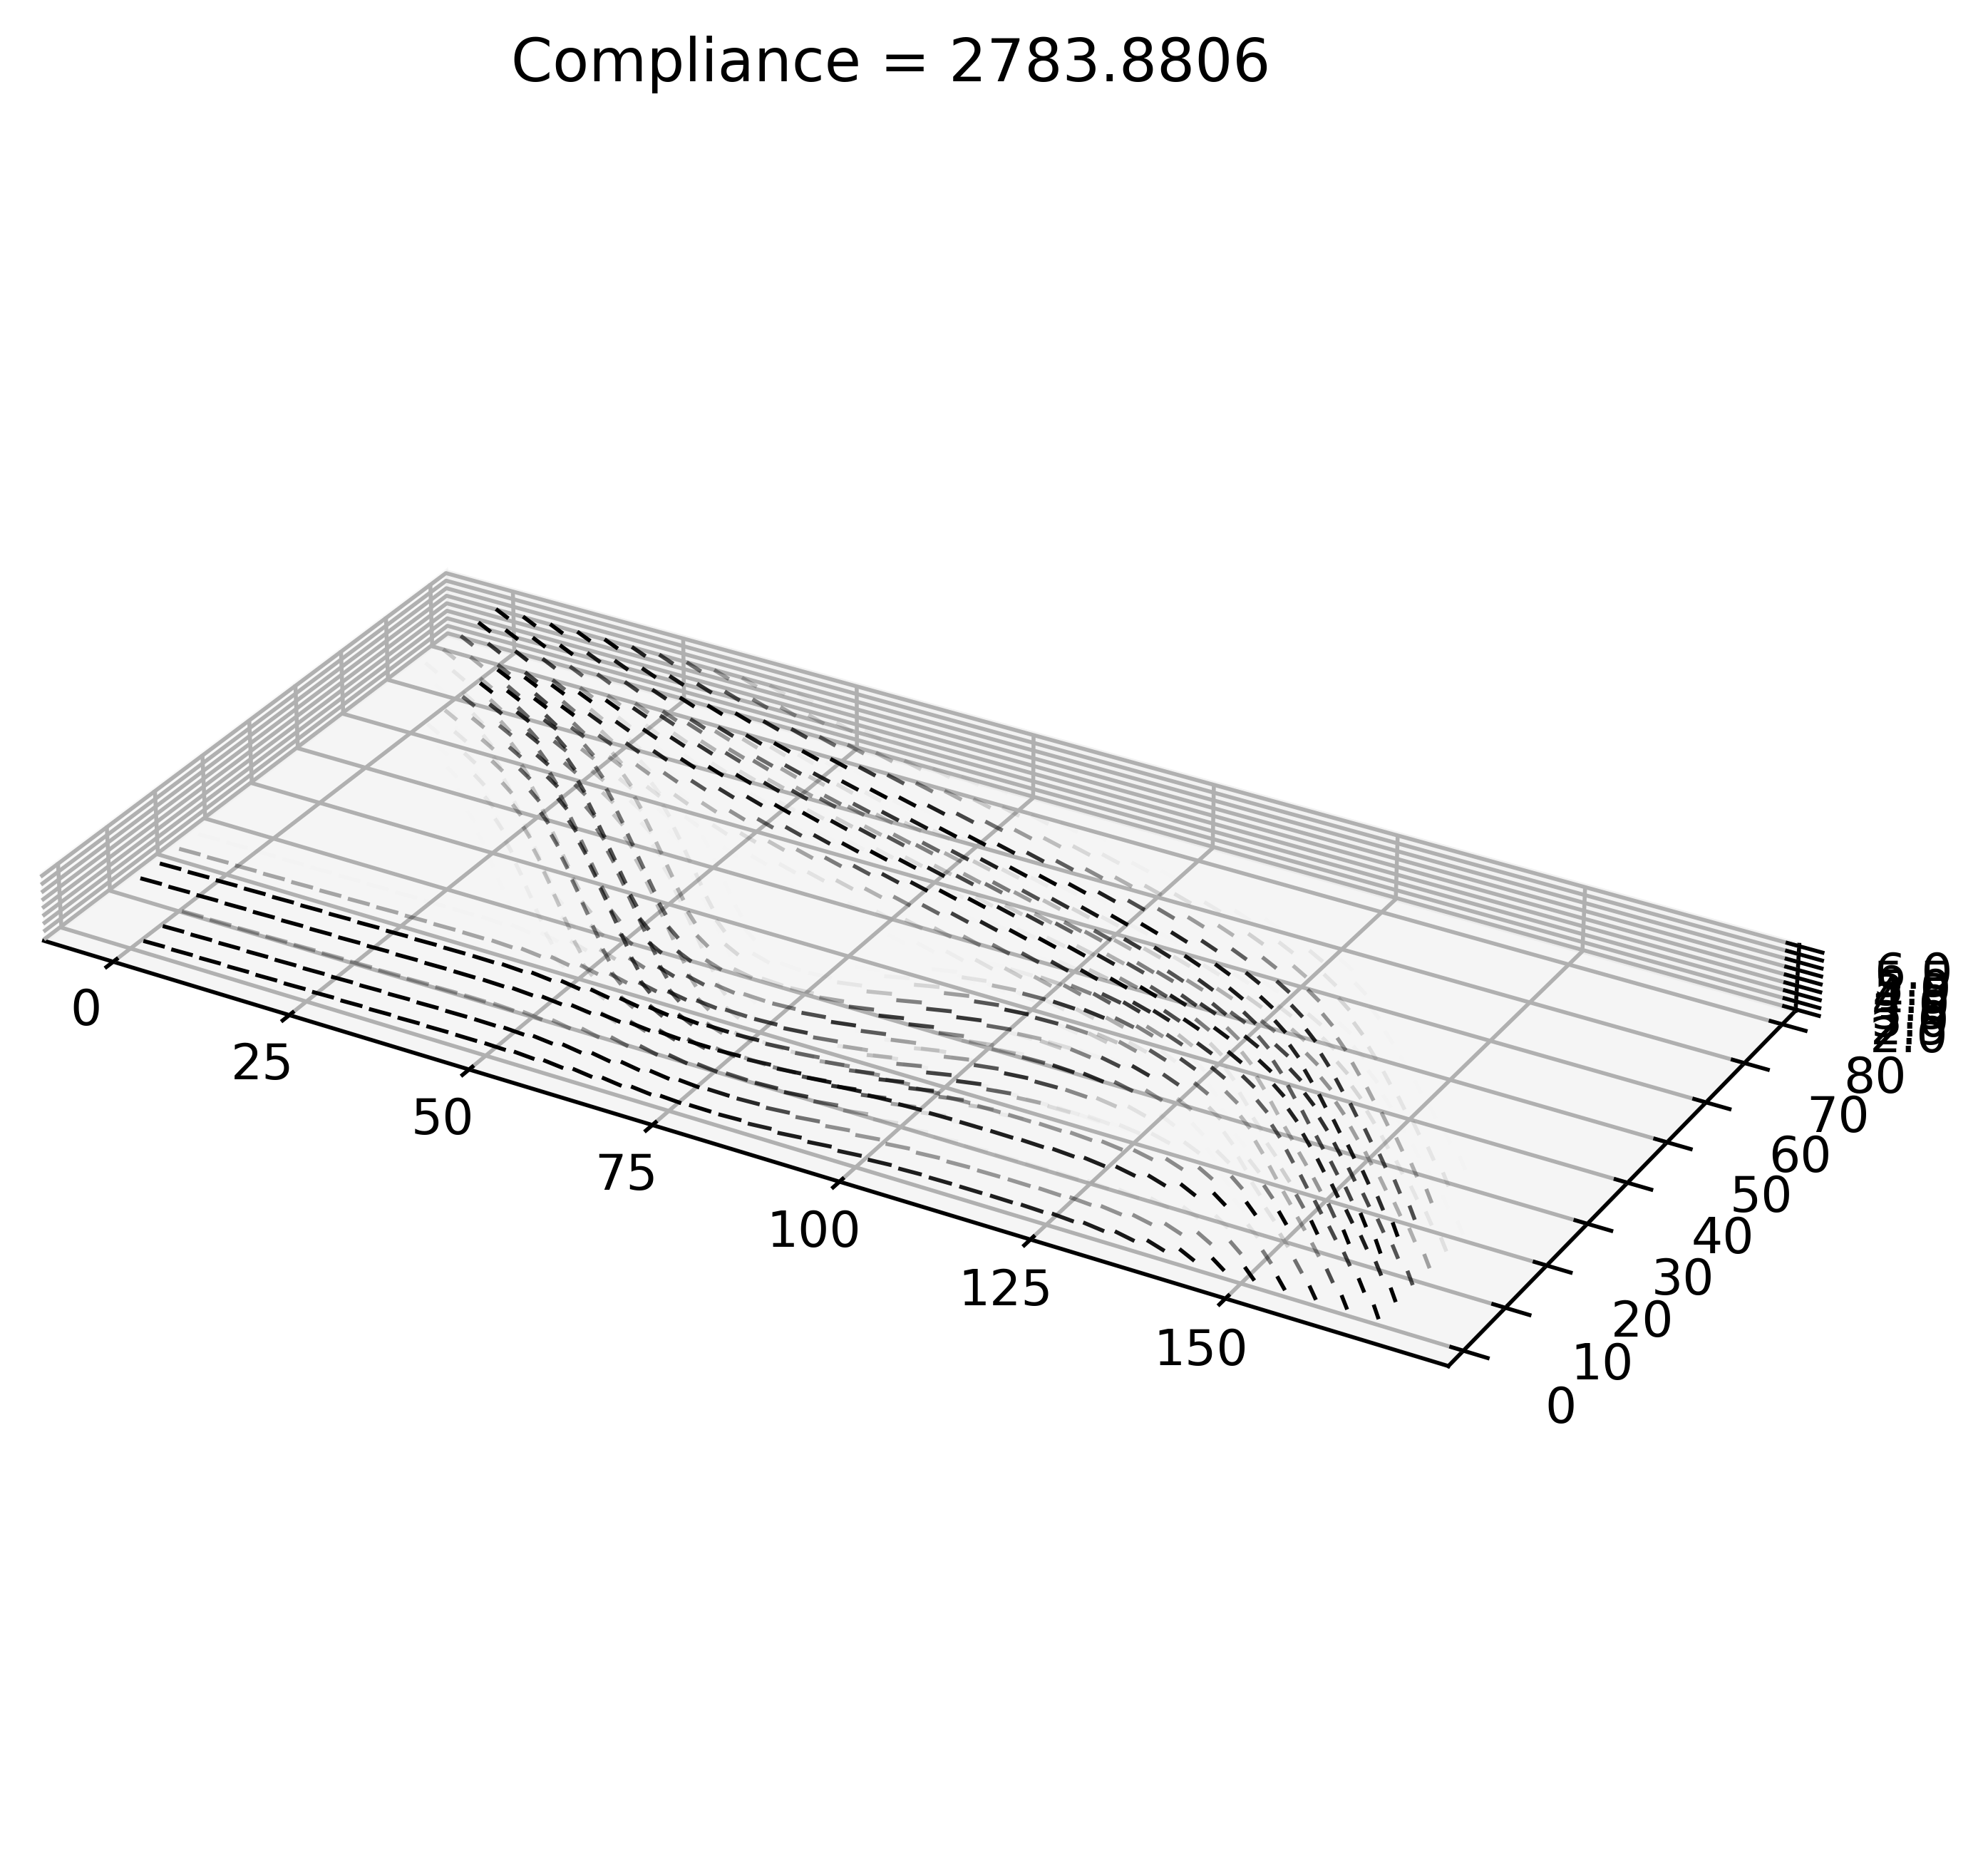

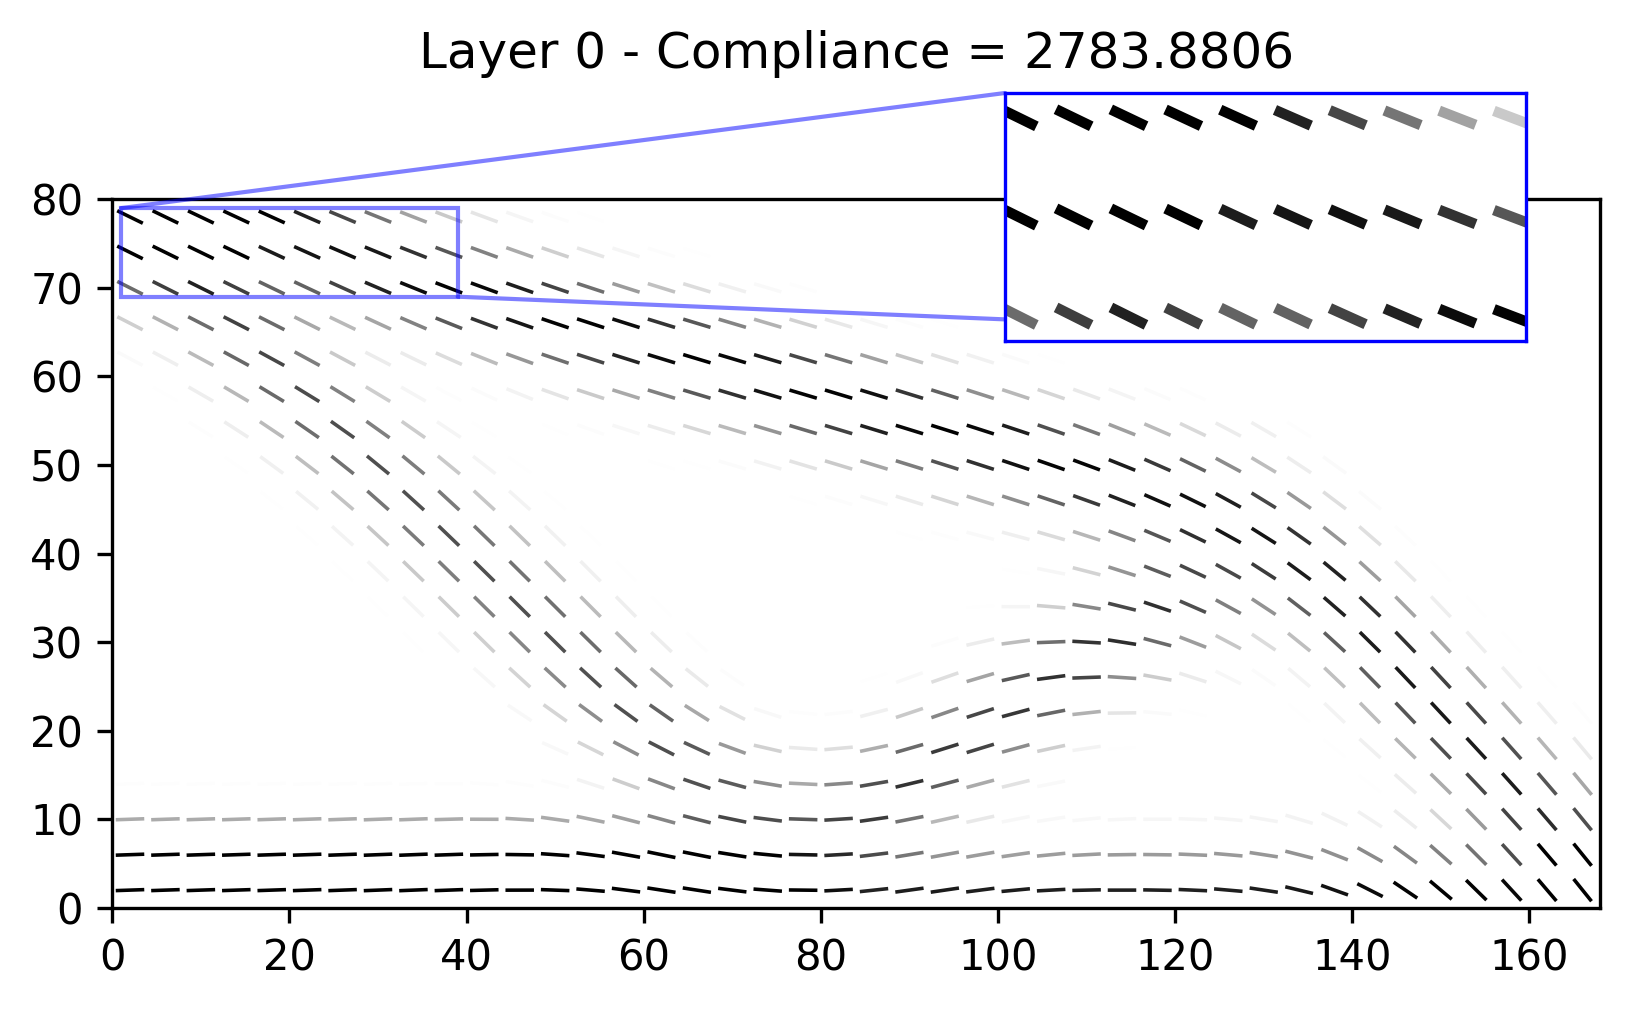

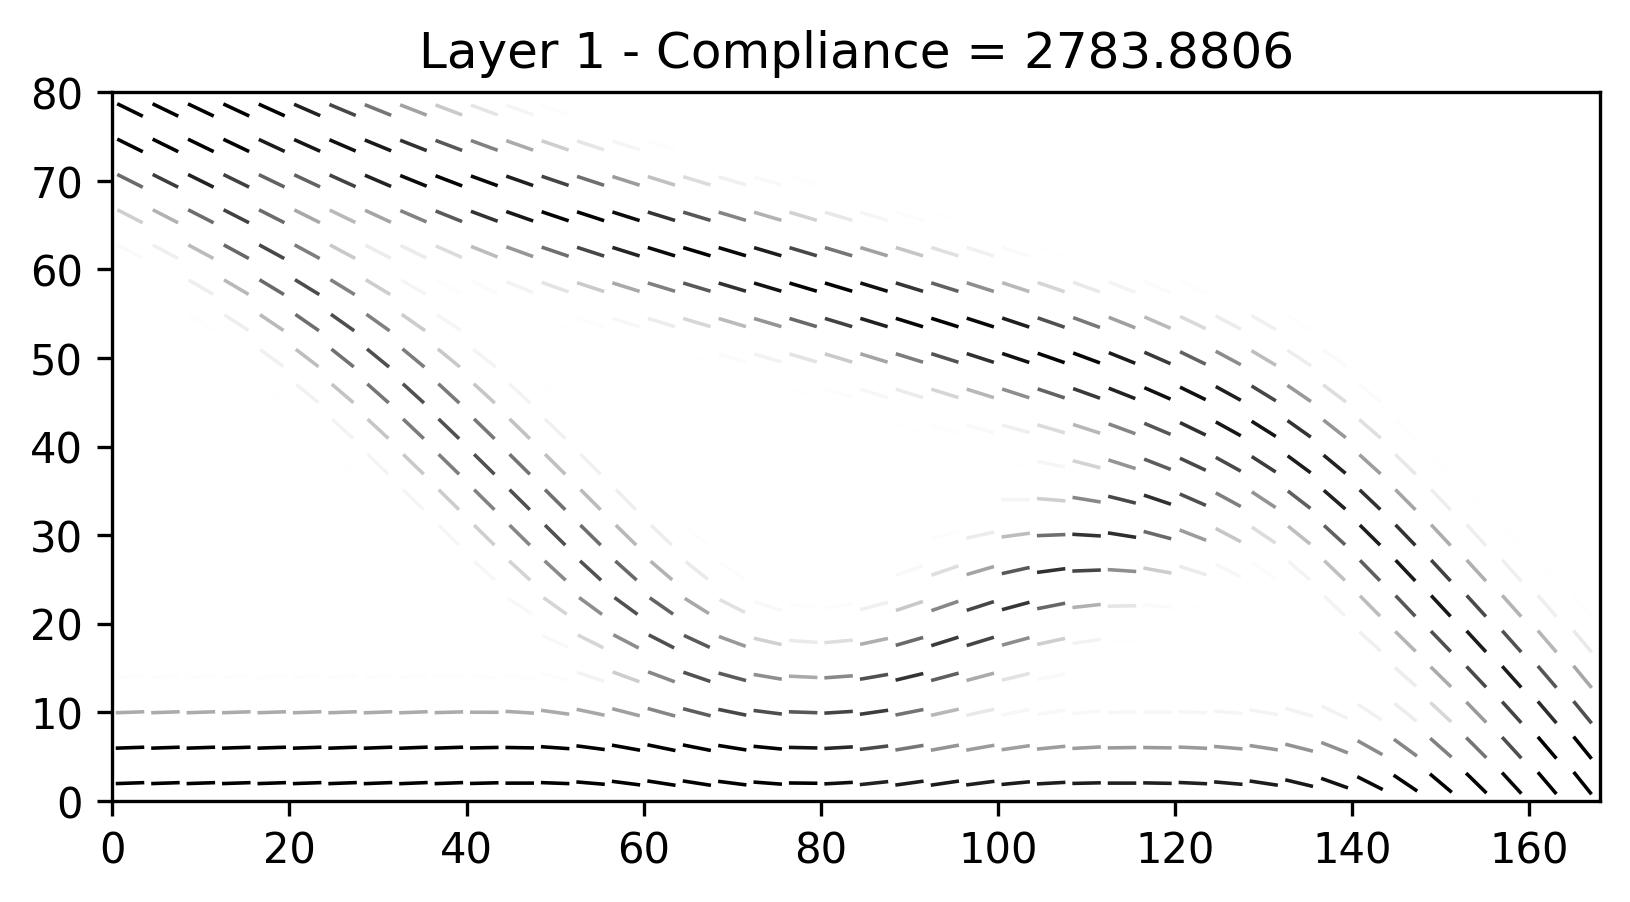

In [6]:
post2 = Post3D(solver2)
post2.plot(colorful=False)
post2.plot_layer(layer=0, zoom=zoom)
post2.plot_layer(layer=1)

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

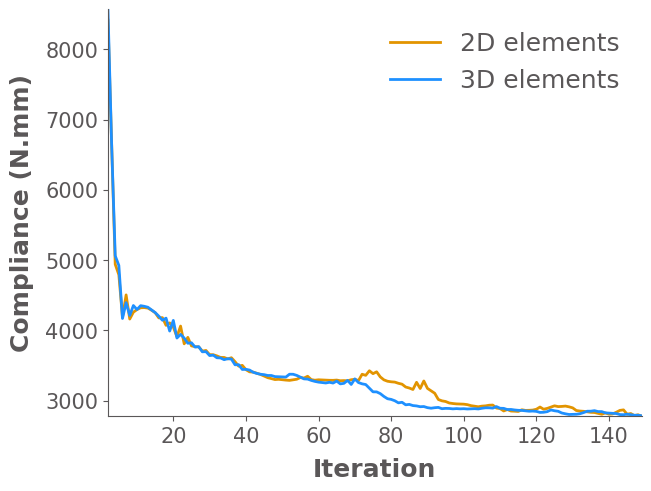

In [7]:
import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())

plt.plot(range(2,150), solver1.comp_hist[2:150], label='2D elements')
plt.plot(range(2,150), solver2.comp_hist[2:150], label='3D elements')
plt.ylabel('Compliance (N.mm)')
plt.xlabel('Iteration')
plt.legend()